In [1]:
from fastai.text.all import *

In [2]:
lang = 'de'
path = Path('.')
model_path = Path(f'{path.absolute()}/data/model')
spm_path = Path(path/'data/model/spm_de_ft')
lm_fns = [model_path/f'{lang}_wikitext', model_path/f'{lang}_wikitext_vocab']

In [3]:
bs = 64

## Prepare corpus for fine tuning

In [4]:
names = ['text','label','label1,']

In [5]:
df_train = pd.read_csv(path/'data/germeval2018/germeval2018.training.txt',
                sep ='\t', names=names)

In [6]:
df_valid = pd.read_csv(path/'data/germeval2018/germeval2018.test.txt',
                sep ='\t', names=names)

In [7]:
df_train2 = pd.read_csv(path/'data/germeval2019/germeval2019.training_subtask1_2_korrigiert.txt',
                sep = '\t', names=names)

In [8]:
df_train3 = pd.read_csv(path/'data/germeval2019/germeval2019.training_subtask3.txt',
                sep = '\t', names=[*names,'label3'])
df_train3.drop('label3', axis=1)

,text,label,"label1,"
0,@spdde kein verläßlicher Verhandlungspartner. Nachkarteln nach den Sondierzngsgesprächen - schickt diese Stümper #SPD in die Versenkung.,OFFENSE,INSULT
1,@milenahanm 33 bis 45 habe ich noch gar nicht gelebt und es geht mir am Arsch vorbei was in dieser Zeit geschehen ist. Ich lebe im heute und jetzt und nicht in der Vergangenheit.,OFFENSE,PROFANITY
2,@tagesschau Euere AfD Hetze wirkt. Da könnt ihr stolz sein bei #ARD-Fernsehen,OFFENSE,ABUSE
3,"Deutsche Medien, Halbwahrheiten und einseitige Betrachtung, wie bei allen vom Staat finanzierten ""billigen"" Propagandainstitutionen 😜",OFFENSE,ABUSE
4,@Ralf_Stegner Oman Ralle..dich mag ja immer noch keiner. Du willst das die Hetze gegen dich aufhört? |LBR| Geh in Rente und verzichte auf die 1/2deiner Pension,OFFENSE,INSULT
...,...,...,...
1916,@Alltags_Kotze Dein Feminismus und Genderquatsch steht Dir im Weg,OFFENSE,ABUSE
1917,@UdoUlfkotte Hauptsache den Asylanten gehts gesundheitlich gut. Deutsche Patienten(Rentner) können sehen wo sie bleiben.,OFFENSE,ABUSE
1918,"@SteinbachErika Ich finde AFD Wähler besser als fettige Hasenscharten, die auf Kosten aller permanent am schmarotzen sind.",OFFENSE,INSULT
1919,"@RKnillmann @lawyerberlin @AfD Aha, der Islam ist eine Religion 😂😂😂",OFFENSE,ABUSE


In [9]:
df = pd.concat([df_train, df_valid,df_train2,df_train3], sort=False)

## Fine tune model

In [10]:
tok = SentencePieceTokenizer(lang=lang, cache_dir=spm_path)

In [11]:
dblocks = DataBlock(blocks=(TextBlock.from_df('text', tok=tok, is_lm=True)),
                    get_x=ColReader('text'), 
                    splitter=RandomSplitter(valid_pct=0.1, seed=42))
dls = dblocks.dataloaders(df)

/home/florian/miniconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [12]:
learn = language_model_learner(dls, AWD_LSTM, drop_mult=0.5, pretrained=True, pretrained_fnames=lm_fns, 
                               metrics=[accuracy, Perplexity()]).to_native_fp16()
learn.path = model_path

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.10000000149011612)

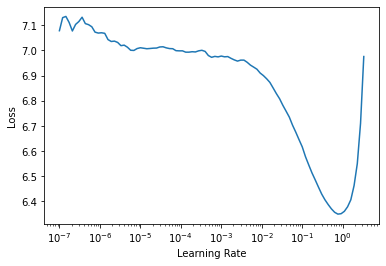

In [13]:
learn.lr_find()

In [14]:
lr = 1e-2
lr *= bs/48  # Scale learning rate by batch size

In [15]:
learn.fit_one_cycle(1, lr*10, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.709624,4.316468,0.294795,74.923546,00:12


In [16]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(lr/10,lr*10), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.060061,4.200886,0.302267,66.745461,00:13
1,3.950277,4.043122,0.320503,57.004047,00:13
2,3.513793,3.875494,0.345119,48.206516,00:13
3,2.899272,3.790438,0.370506,44.275795,00:13
4,2.347292,3.871211,0.377023,48.000458,00:13


## Saving fine tuned model, encoder and vocab

In [17]:
lm_ft_fns = [model_path/f'{lang}_ft', model_path/f'{lang}_ft_vocab.pkl']

In [18]:
learn.to_fp32()

In [19]:
learn.save(lm_ft_fns[0], with_opt=False)

Path('/data/projects/git/fastai_ulmfit_german/data/model/de_ft.pth')

In [20]:
learn.save_encoder(f'{lm_ft_fns[0]}_encoder')

In [21]:
with open(lm_ft_fns[1], 'wb') as f:
      pickle.dump(learn.dls.vocab, f)